In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/covid-19/orginal covid-19.zip'

Archive:  /content/drive/MyDrive/covid-19/orginal covid-19.zip
   creating: orginal covid-19/
   creating: orginal covid-19/test/
   creating: orginal covid-19/test/covid-19/
  inflating: orginal covid-19/test/covid-19/COVID-TT- (1).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (10).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (11).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (12).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (13).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (14).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (15).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (16).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (17).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (18).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (19).png  
  inflating: orginal covid-19/test/covid-19/COVID-TT- (2).png  
  inflating: orginal covid-19/test/covid-19/COV

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

[Data Scorce](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [ ]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['covid-19', 'normal']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [ ]:
class CFG:

  epochs =100                             # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  #Data_DIR = "chest_xray"
  #TEST = "test"
  #TRAIN = "train"
  #VAL = "val"
  train_path='/content/orginal covid-19/train'
  validate_path='/content/orginal covid-19/valid'
  test_path='/content/orginal covid-19/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))


  

On which device we are on:cuda


In [ ]:
from torchvision import transforms as T,datasets

In [ ]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [ ]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  2000


In [ ]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  50


In [ ]:
testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

testset Size:  50


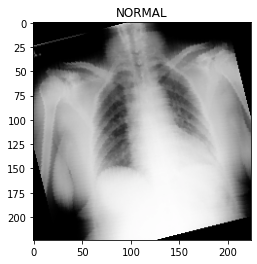

In [ ]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["NORMAL","COVID-19"]
show_image(img,class_name[label])

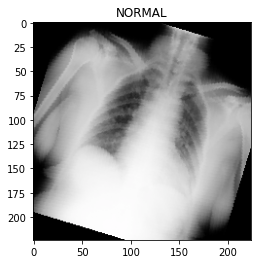

In [ ]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["NORMAL","COVID-19"]
show_image(img,class_name[label]) 

# randomly rotated

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:125
No. of Total examples:2000


In [ ]:
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:4
No. of Total examples:50


In [ ]:
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:4
No. of Total examples:50


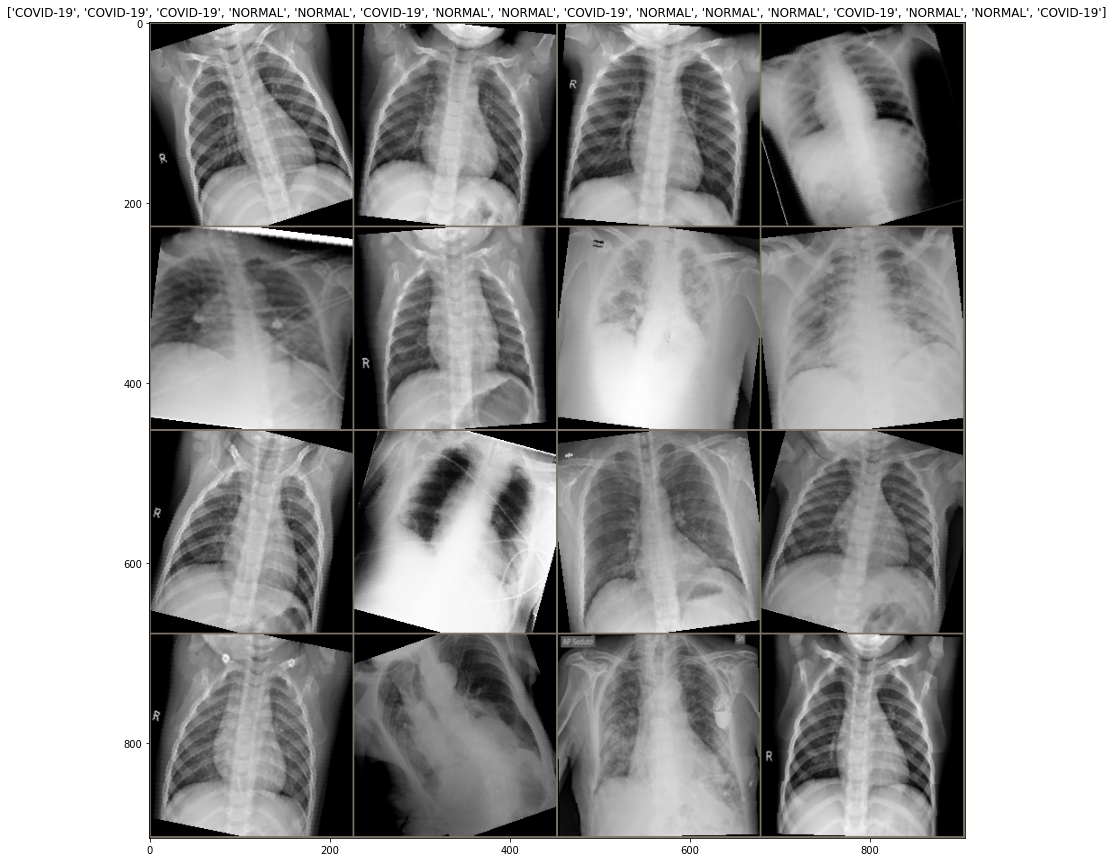

In [ ]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [ ]:
!pip install timm # install PyTorch Image Models

     |████████████████████████████████| 348kB 8.3MB/s 


In [ ]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


In [ ]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv

In [ ]:
#let's update the pretarined model:
for param in model.parameters():
  param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv

In [ ]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
    SqueezeExcite-10         [-1, 48, 112, 112]               0
           Conv2d-11         [-1, 24, 112, 112]           1,152
      BatchNorm2d-12         [-1, 24, 112, 112]              48
         Identity-13         [-1, 24, 112, 112]               0
DepthwiseSeparableConv-14         [-1, 

In [ ]:
class covidTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'Covid-19Model.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = covidTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)


Valid_loss decreased inf --> 0.9962405413389206
Epoch : 1 Train Loss : 0.254239 Train Acc : 0.912500
Epoch : 1 Valid Loss : 0.996241 Valid Acc : 0.437500



Valid_loss decreased 0.9962405413389206 --> 0.9730691164731979
Epoch : 2 Train Loss : 0.171977 Train Acc : 0.935000
Epoch : 2 Valid Loss : 0.973069 Valid Acc : 0.578125



Valid_loss decreased 0.9730691164731979 --> 0.7609921395778656
Epoch : 3 Train Loss : 0.179564 Train Acc : 0.936000
Epoch : 3 Valid Loss : 0.760992 Valid Acc : 0.718750



Valid_loss decreased 0.7609921395778656 --> 0.6219755709171295
Epoch : 4 Train Loss : 0.147774 Train Acc : 0.943500
Epoch : 4 Valid Loss : 0.621976 Valid Acc : 0.703125



Valid_loss decreased 0.6219755709171295 --> 0.5700173899531364
Epoch : 5 Train Loss : 0.132960 Train Acc : 0.953500
Epoch : 5 Valid Loss : 0.570017 Valid Acc : 0.781250



Epoch : 6 Train Loss : 0.156795 Train Acc : 0.945500
Epoch : 6 Valid Loss : 0.700895 Valid Acc : 0.671875



Epoch : 7 Train Loss : 0.134094 Train Acc : 0.946000
Epoch : 7 Valid Loss : 0.913202 Valid Acc : 0.656250



Epoch : 8 Train Loss : 0.132932 Train Acc : 0.946000
Epoch : 8 Valid Loss : 0.648903 Valid Acc : 0.609375



Epoch : 9 Train Loss : 0.131655 Train Acc : 0.948000
Epoch : 9 Valid Loss : 0.650480 Valid Acc : 0.750000



Epoch : 10 Train Loss : 0.119301 Train Acc : 0.954000
Epoch : 10 Valid Loss : 0.955580 Valid Acc : 0.640625



Epoch : 11 Train Loss : 0.136506 Train Acc : 0.949500
Epoch : 11 Valid Loss : 0.926928 Valid Acc : 0.562500



Epoch : 12 Train Loss : 0.117124 Train Acc : 0.955000
Epoch : 12 Valid Loss : 0.864652 Valid Acc : 0.578125



Epoch : 13 Train Loss : 0.114219 Train Acc : 0.963500
Epoch : 13 Valid Loss : 1.092834 Valid Acc : 0.562500



Epoch : 14 Train Loss : 0.113998 Train Acc : 0.960000
Epoch : 14 Valid Loss : 0.852928 Valid Acc : 0.734375



Epoch : 15 Train Loss : 0.101232 Train Acc : 0.961500
Epoch : 15 Valid Loss : 0.583439 Valid Acc : 0.734375



Epoch : 16 Train Loss : 0.130396 Train Acc : 0.956000
Epoch : 16 Valid Loss : 1.035473 Valid Acc : 0.562500



Epoch : 17 Train Loss : 0.114247 Train Acc : 0.960500
Epoch : 17 Valid Loss : 0.880055 Valid Acc : 0.640625



Epoch : 18 Train Loss : 0.116588 Train Acc : 0.962500
Epoch : 18 Valid Loss : 0.724775 Valid Acc : 0.687500



Valid_loss decreased 0.5700173899531364 --> 0.5574787519872189
Epoch : 19 Train Loss : 0.101838 Train Acc : 0.959000
Epoch : 19 Valid Loss : 0.557479 Valid Acc : 0.718750



Epoch : 20 Train Loss : 0.105932 Train Acc : 0.958000
Epoch : 20 Valid Loss : 0.617752 Valid Acc : 0.734375



Epoch : 21 Train Loss : 0.118342 Train Acc : 0.956000
Epoch : 21 Valid Loss : 0.831702 Valid Acc : 0.609375



Epoch : 22 Train Loss : 0.103089 Train Acc : 0.960000
Epoch : 22 Valid Loss : 0.673612 Valid Acc : 0.687500



Epoch : 23 Train Loss : 0.099119 Train Acc : 0.961000
Epoch : 23 Valid Loss : 0.640746 Valid Acc : 0.703125



Epoch : 24 Train Loss : 0.113017 Train Acc : 0.963500
Epoch : 24 Valid Loss : 1.139582 Valid Acc : 0.437500



Epoch : 25 Train Loss : 0.086755 Train Acc : 0.969500
Epoch : 25 Valid Loss : 0.898824 Valid Acc : 0.781250



Epoch : 26 Train Loss : 0.102047 Train Acc : 0.964000
Epoch : 26 Valid Loss : 0.659904 Valid Acc : 0.781250



Epoch : 27 Train Loss : 0.104705 Train Acc : 0.962500
Epoch : 27 Valid Loss : 0.676424 Valid Acc : 0.765625



Epoch : 28 Train Loss : 0.084705 Train Acc : 0.972500
Epoch : 28 Valid Loss : 0.735896 Valid Acc : 0.765625



Epoch : 29 Train Loss : 0.088555 Train Acc : 0.966000
Epoch : 29 Valid Loss : 1.360747 Valid Acc : 0.625000



Epoch : 30 Train Loss : 0.081503 Train Acc : 0.967500
Epoch : 30 Valid Loss : 0.826196 Valid Acc : 0.703125



Epoch : 31 Train Loss : 0.081508 Train Acc : 0.966000
Epoch : 31 Valid Loss : 1.052249 Valid Acc : 0.593750



Epoch : 32 Train Loss : 0.070543 Train Acc : 0.974500
Epoch : 32 Valid Loss : 1.141343 Valid Acc : 0.562500



Epoch : 33 Train Loss : 0.071245 Train Acc : 0.978000
Epoch : 33 Valid Loss : 0.618192 Valid Acc : 0.609375



Epoch : 34 Train Loss : 0.094098 Train Acc : 0.968500
Epoch : 34 Valid Loss : 0.733745 Valid Acc : 0.718750



Epoch : 35 Train Loss : 0.087362 Train Acc : 0.965000
Epoch : 35 Valid Loss : 0.593620 Valid Acc : 0.781250



Epoch : 36 Train Loss : 0.079925 Train Acc : 0.970500
Epoch : 36 Valid Loss : 0.757420 Valid Acc : 0.671875



Epoch : 37 Train Loss : 0.086587 Train Acc : 0.965500
Epoch : 37 Valid Loss : 0.657263 Valid Acc : 0.765625



Epoch : 38 Train Loss : 0.071488 Train Acc : 0.974500
Epoch : 38 Valid Loss : 0.565396 Valid Acc : 0.765625



Epoch : 39 Train Loss : 0.090861 Train Acc : 0.967500
Epoch : 39 Valid Loss : 0.865145 Valid Acc : 0.625000



Epoch : 40 Train Loss : 0.077747 Train Acc : 0.972000
Epoch : 40 Valid Loss : 0.925700 Valid Acc : 0.593750



Epoch : 41 Train Loss : 0.074345 Train Acc : 0.976000
Epoch : 41 Valid Loss : 0.641794 Valid Acc : 0.703125



Epoch : 42 Train Loss : 0.084529 Train Acc : 0.969500
Epoch : 42 Valid Loss : 0.683281 Valid Acc : 0.734375



Epoch : 43 Train Loss : 0.083111 Train Acc : 0.973000
Epoch : 43 Valid Loss : 0.691057 Valid Acc : 0.765625



Valid_loss decreased 0.5574787519872189 --> 0.46967681124806404
Epoch : 44 Train Loss : 0.072132 Train Acc : 0.971000
Epoch : 44 Valid Loss : 0.469677 Valid Acc : 0.750000



Epoch : 45 Train Loss : 0.084667 Train Acc : 0.967500
Epoch : 45 Valid Loss : 0.504099 Valid Acc : 0.828125



Epoch : 46 Train Loss : 0.071888 Train Acc : 0.977000
Epoch : 46 Valid Loss : 0.787542 Valid Acc : 0.671875



Epoch : 47 Train Loss : 0.083973 Train Acc : 0.969500
Epoch : 47 Valid Loss : 0.692746 Valid Acc : 0.796875



Epoch : 48 Train Loss : 0.055838 Train Acc : 0.984000
Epoch : 48 Valid Loss : 0.824090 Valid Acc : 0.671875



Epoch : 49 Train Loss : 0.065485 Train Acc : 0.981500
Epoch : 49 Valid Loss : 1.573740 Valid Acc : 0.515625



Epoch : 50 Train Loss : 0.103234 Train Acc : 0.966000
Epoch : 50 Valid Loss : 0.877956 Valid Acc : 0.718750



Epoch : 51 Train Loss : 0.077257 Train Acc : 0.967500
Epoch : 51 Valid Loss : 0.932496 Valid Acc : 0.671875



Epoch : 52 Train Loss : 0.074223 Train Acc : 0.976500
Epoch : 52 Valid Loss : 0.602634 Valid Acc : 0.765625



Epoch : 53 Train Loss : 0.077484 Train Acc : 0.968000
Epoch : 53 Valid Loss : 0.726556 Valid Acc : 0.718750



Epoch : 54 Train Loss : 0.082520 Train Acc : 0.967500
Epoch : 54 Valid Loss : 1.059342 Valid Acc : 0.609375



Epoch : 55 Train Loss : 0.073731 Train Acc : 0.970000
Epoch : 55 Valid Loss : 0.649722 Valid Acc : 0.750000



Epoch : 56 Train Loss : 0.067552 Train Acc : 0.975000
Epoch : 56 Valid Loss : 0.694658 Valid Acc : 0.750000



Epoch : 57 Train Loss : 0.076272 Train Acc : 0.970000
Epoch : 57 Valid Loss : 0.688696 Valid Acc : 0.765625



Epoch : 58 Train Loss : 0.075251 Train Acc : 0.974500
Epoch : 58 Valid Loss : 0.631249 Valid Acc : 0.640625



Epoch : 59 Train Loss : 0.074723 Train Acc : 0.974500
Epoch : 59 Valid Loss : 0.562486 Valid Acc : 0.718750



Epoch : 60 Train Loss : 0.073988 Train Acc : 0.973500
Epoch : 60 Valid Loss : 0.552181 Valid Acc : 0.765625



Epoch : 61 Train Loss : 0.064575 Train Acc : 0.977500
Epoch : 61 Valid Loss : 0.729903 Valid Acc : 0.484375



Epoch : 62 Train Loss : 0.062657 Train Acc : 0.975500
Epoch : 62 Valid Loss : 0.893724 Valid Acc : 0.734375



Epoch : 63 Train Loss : 0.059356 Train Acc : 0.982000
Epoch : 63 Valid Loss : 0.699957 Valid Acc : 0.734375



Epoch : 64 Train Loss : 0.068381 Train Acc : 0.978000
Epoch : 64 Valid Loss : 0.637042 Valid Acc : 0.718750



Epoch : 65 Train Loss : 0.056741 Train Acc : 0.976500
Epoch : 65 Valid Loss : 1.058150 Valid Acc : 0.671875



Epoch : 66 Train Loss : 0.061651 Train Acc : 0.978000
Epoch : 66 Valid Loss : 0.782199 Valid Acc : 0.734375



Epoch : 67 Train Loss : 0.070881 Train Acc : 0.975500
Epoch : 67 Valid Loss : 1.129299 Valid Acc : 0.609375



Epoch : 68 Train Loss : 0.065463 Train Acc : 0.978500
Epoch : 68 Valid Loss : 1.126227 Valid Acc : 0.656250



Epoch : 69 Train Loss : 0.069066 Train Acc : 0.980500
Epoch : 69 Valid Loss : 1.714409 Valid Acc : 0.453125



Epoch : 70 Train Loss : 0.066533 Train Acc : 0.981500
Epoch : 70 Valid Loss : 0.875196 Valid Acc : 0.625000



Epoch : 71 Train Loss : 0.059874 Train Acc : 0.979500
Epoch : 71 Valid Loss : 0.945414 Valid Acc : 0.625000



Epoch : 72 Train Loss : 0.080270 Train Acc : 0.971000
Epoch : 72 Valid Loss : 0.954498 Valid Acc : 0.671875



Epoch : 73 Train Loss : 0.051531 Train Acc : 0.981000
Epoch : 73 Valid Loss : 0.822153 Valid Acc : 0.687500



Epoch : 74 Train Loss : 0.063025 Train Acc : 0.975500
Epoch : 74 Valid Loss : 1.120339 Valid Acc : 0.609375



Epoch : 75 Train Loss : 0.063978 Train Acc : 0.974500
Epoch : 75 Valid Loss : 1.070577 Valid Acc : 0.625000



Epoch : 76 Train Loss : 0.072656 Train Acc : 0.975500
Epoch : 76 Valid Loss : 1.095412 Valid Acc : 0.484375



Epoch : 77 Train Loss : 0.056797 Train Acc : 0.976000
Epoch : 77 Valid Loss : 1.020424 Valid Acc : 0.468750



Epoch : 78 Train Loss : 0.056582 Train Acc : 0.980500
Epoch : 78 Valid Loss : 1.063772 Valid Acc : 0.656250



Epoch : 79 Train Loss : 0.067555 Train Acc : 0.976000
Epoch : 79 Valid Loss : 0.640745 Valid Acc : 0.765625



Epoch : 80 Train Loss : 0.059512 Train Acc : 0.980000
Epoch : 80 Valid Loss : 0.528531 Valid Acc : 0.765625



Epoch : 81 Train Loss : 0.054076 Train Acc : 0.979000
Epoch : 81 Valid Loss : 1.167258 Valid Acc : 0.578125



Epoch : 82 Train Loss : 0.055423 Train Acc : 0.975500
Epoch : 82 Valid Loss : 0.977556 Valid Acc : 0.703125



Epoch : 83 Train Loss : 0.056537 Train Acc : 0.977000
Epoch : 83 Valid Loss : 0.962678 Valid Acc : 0.656250



Epoch : 84 Train Loss : 0.049632 Train Acc : 0.980000
Epoch : 84 Valid Loss : 0.815367 Valid Acc : 0.671875



Epoch : 85 Train Loss : 0.050678 Train Acc : 0.981000
Epoch : 85 Valid Loss : 0.753498 Valid Acc : 0.796875



Epoch : 86 Train Loss : 0.053841 Train Acc : 0.979000
Epoch : 86 Valid Loss : 1.202691 Valid Acc : 0.687500



Epoch : 87 Train Loss : 0.050439 Train Acc : 0.981000
Epoch : 87 Valid Loss : 1.177188 Valid Acc : 0.671875



Epoch : 88 Train Loss : 0.059757 Train Acc : 0.978500
Epoch : 88 Valid Loss : 1.781862 Valid Acc : 0.625000



Epoch : 89 Train Loss : 0.050625 Train Acc : 0.979500
Epoch : 89 Valid Loss : 1.512785 Valid Acc : 0.656250



Epoch : 90 Train Loss : 0.051666 Train Acc : 0.981500
Epoch : 90 Valid Loss : 0.695826 Valid Acc : 0.687500



Epoch : 91 Train Loss : 0.064246 Train Acc : 0.978500
Epoch : 91 Valid Loss : 0.677467 Valid Acc : 0.812500



Epoch : 92 Train Loss : 0.045507 Train Acc : 0.983500
Epoch : 92 Valid Loss : 0.697186 Valid Acc : 0.781250



Epoch : 93 Train Loss : 0.047759 Train Acc : 0.985500
Epoch : 93 Valid Loss : 0.855351 Valid Acc : 0.703125



Epoch : 94 Train Loss : 0.062239 Train Acc : 0.978000
Epoch : 94 Valid Loss : 0.953426 Valid Acc : 0.718750



Epoch : 95 Train Loss : 0.052188 Train Acc : 0.981000
Epoch : 95 Valid Loss : 1.275266 Valid Acc : 0.640625



Epoch : 96 Train Loss : 0.061181 Train Acc : 0.983000
Epoch : 96 Valid Loss : 0.783209 Valid Acc : 0.750000



Epoch : 97 Train Loss : 0.056297 Train Acc : 0.979500
Epoch : 97 Valid Loss : 0.540185 Valid Acc : 0.843750



Epoch : 98 Train Loss : 0.063486 Train Acc : 0.976000
Epoch : 98 Valid Loss : 0.949436 Valid Acc : 0.750000



Epoch : 99 Train Loss : 0.058502 Train Acc : 0.977000
Epoch : 99 Valid Loss : 1.241500 Valid Acc : 0.671875



Epoch : 100 Train Loss : 0.059214 Train Acc : 0.980500
Epoch : 100 Valid Loss : 0.868047 Valid Acc : 0.750000


In [ ]:
model.load_state_dict(torch.load('/content/Covid-19Model.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))


Test Loss : 0.7195643037557602
Test Acc : 0.546875


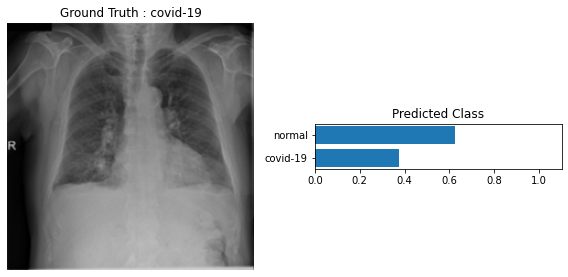

In [ ]:
import torch.nn.functional as F

image,label = testset[10]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

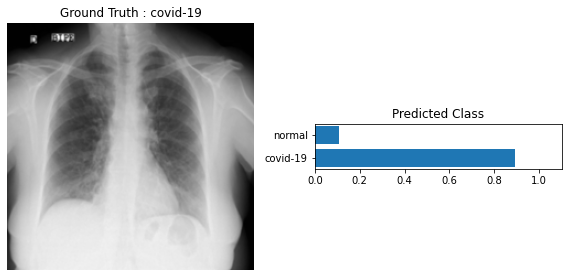

In [ ]:
import torch.nn.functional as F

image,label = testset[5]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

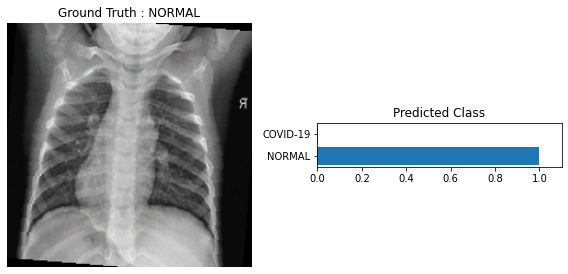

In [ ]:
import torch.nn.functional as F

image,label = trainset[15]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

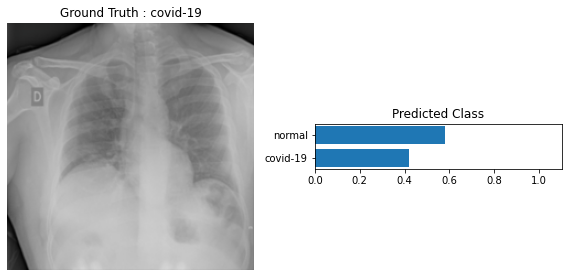

In [ ]:
import torch.nn.functional as F

image,label = testset[16]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)